In [9]:
import h5py
import numpy as np
from scipy.io import loadmat
from fw_i2cm1i_graphcut import fw_i2cm1i_graphcut
from fwFit_MagnLS_1r2star import fwFit_MagnLS_1r2star
from computeFF import computeFF
from create_robust_mask import create_robust_mask

In [10]:

# Open the HDF5 file
file = h5py.File('/home/dxt005/home/Tools/WaterFatPython/Data/invivo_FF10p/IdealChanCombData_25544_4.h5', 'r')

xres = file['Header']['ImageXRes'][0]
yres = file['Header']['ImageYRes'][0]
nslices = file['Header']['NumSlices'][0]
nTE = file['Header']['NumEchoes'][0]
TEs = file['Header']['EchoTimes'][0:nTE]
FieldStrength = file['Header']['FieldStrength'][0]

ims = np.zeros((xres, yres, nTE, nslices), dtype=np.cdouble)

# Iterate over each key
for sl in range(len(file['Data'].keys())):
    # Get the data
    key = 'Slice%d' % (sl)
    data = np.array(list(file['Data'][key]))
    data_c = data['real'] + 1j*data['imag']
    ims[:,:,:,sl] = data_c.transpose((2,1,0))

ims = ims/np.max(np.abs(ims))*100


In [11]:

# Setup params
PROCESS_PHANTOM = 0


fatAmps = np.array([0.087, 0.693, 0.128, 0.004, 0.039, 0.048])
fatFreq = np.array([-3.80, -3.40, -2.60, -1.94, -0.39, 0.60])
if PROCESS_PHANTOM==1:
	fatFreq = fatFreq - 0.08

algoParams = {
    'species': [
        {
            'name': 'water',
            'frequency': np.array([0.0]),
            'relAmps': np.array([1.0])
        },
        {
            'name': 'fat',
            'frequency': fatFreq,
            'relAmps': fatAmps
        }
    ],
    'size_clique':1,
    'range_r2star':np.array([0, 1000]),
    'NUM_R2STARS':11,
    'range_fm':np.array([-600, 600]),
    'NUM_FMS':101,
    'NUM_ITERS':40,
    'SUBSAMPLE':4,#4
    'DO_OT':0,
    'LMAP_POWER':2,
    'lambda':0.02,
    'LMAP_EXTRA':0.02,
    'TRY_PERIODIC_RESIDUAL':0
}

imDataParams = {
    'TE': TEs,
    'FieldStrength':FieldStrength/10000.0,
    'PrecessionIsClockwise': -1,
    'images':np.array([0, 0])
}

In [12]:

import time

R2s3D = np.zeros((xres, yres, nslices))
PDFF3D = np.zeros((xres, yres, nslices))
Water3D = np.zeros((xres, yres, nslices))
Fat3D = np.zeros((xres, yres, nslices))

for sl in range(16,17):

    print('Slice %d'%(sl))
      
    imDataParams['images'] = ims[:,:,:,sl].reshape(xres, yres, 1, 1, nTE,1)
     
    mask = create_robust_mask(np.abs(ims[:,:,0,sl]), percentile_low=0, percentile_high=50)  
  
    start = time.time()
    initParams = fw_i2cm1i_graphcut(imDataParams, algoParams)
    initParams['masksignal'] = mask
    end = time.time()
    print("Process Time initParams: %f" % (end - start))

    start = time.time()
    outParams = fwFit_MagnLS_1r2star(imDataParams, algoParams, initParams)
    end = time.time()
    print("Process Time fwFit_ComplexLS_1r2star: %f" % (end - start))
        
    Water3D[:,:,sl] =  initParams['amp_w']
    Fat3D[:,:,sl] =  initParams['amp_f']
    R2s3D[:,:,sl] = outParams['r2starmap']
    PDFF3D[:,:,sl] = computeFF( outParams )


Slice 16
Process Time estimateR2starGivenFieldmap: 1.244988
Process Time decomposeGivenFieldMapAndDampings: 1.752254
Process Time initParams: 4.769909
Process Time fwFit_ComplexLS_1r2star: 0.764385


/tmp/ipykernel_454681/63623206.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  Water3D[:,:,sl] =  initParams['amp_w']
/tmp/ipykernel_454681/63623206.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  Fat3D[:,:,sl] =  initParams['amp_f']


In [7]:
import ipywidgets as widgets
image_widget = widgets.Image(value=np.abs(Water3D[:,:,16]))

display(image_widget)


Image(value=b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00…

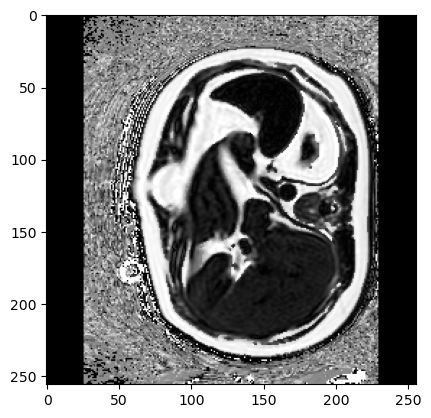

In [8]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(PDFF3D[:,:,16]), cmap='gray',vmin=0, vmax=100)
plt.show()


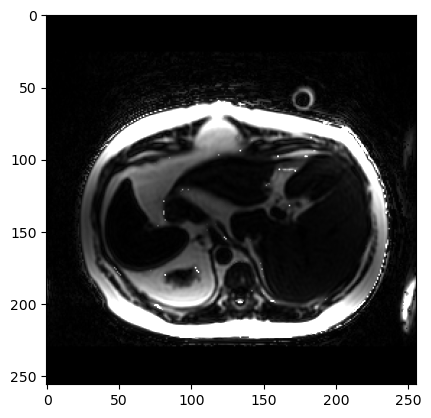

In [6]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(initParams['amp_f']), cmap='gray',vmin=0, vmax=30)
plt.show()


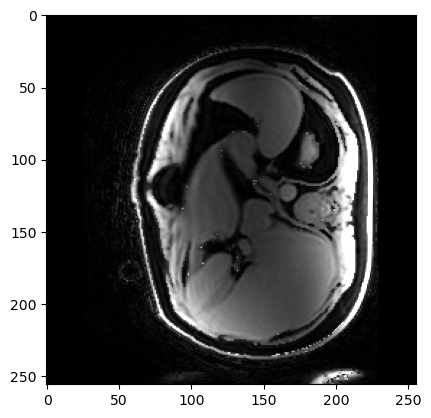

In [6]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(outParams['water_amp']), cmap='gray',vmin=0, vmax=30)
plt.show()

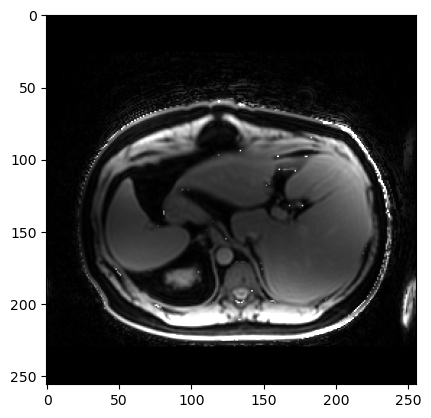

In [9]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(initParams['amp_w']), cmap='gray',vmin=0, vmax=30)
plt.show()


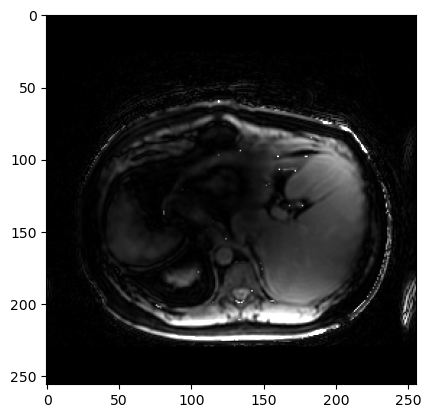

In [11]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(Water3D[:,:,16]), cmap='gray',vmin=0, vmax=30.0)
plt.show()


In [13]:
initParams


{'fm': array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        , -48.        , -48.        , ..., -60.        ,
           0.        ,   0.        ],
        [  0.        , -48.        , -48.        , ..., -60.        ,
           0.        ,   0.        ],
        ...,
        [  0.        , -72.        , -72.00000005, ..., -72.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]),
 'amp_w': array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+